In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from pipeline_simulator.batches import ForwardBatch, BackwardInputBatch, BackwardWeightBatch
from pipeline_simulator.batches import update_times
from pipeline_simulator.policy import PipeDreamPolicy, OurPolicy, FixedPolicy
from pipeline_simulator.schedule import PipelineSimulator

<Figure size 900x250 with 0 Axes>

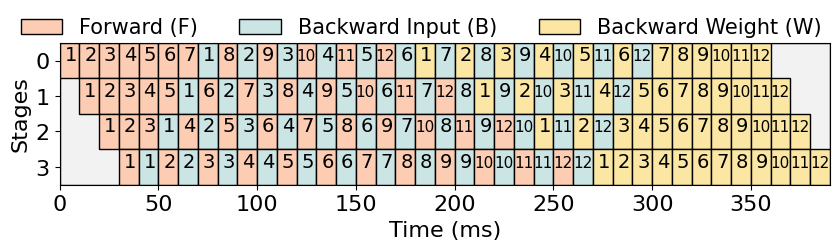

In [2]:
'''The following code produces Figure.4 in the paper: the ideal ZeroBubble schedule'''
num_stages, num_batches = 4, 12
update_times([10]*num_stages, [10]*num_stages, [10]*num_stages, [1]*num_stages)
policy = OurPolicy(num_stages)
plt.figure(figsize=(9, 2.5))
simulator = PipelineSimulator(num_stages, num_batches, policy, [], {}, True)
simulator.simulate()
simulator.plot()
plt.title("")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.bar(0, 0, label="Forward (F)", color=ForwardBatch(0).color, edgecolor='black')
plt.bar(0, 0, label="Backward Input (B)", color=BackwardInputBatch(0).color, edgecolor='black')
plt.bar(0, 0, label="Backward Weight (W)", color=BackwardWeightBatch(0).color, edgecolor='black')
plt.xlabel("Time (ms)", fontdict={"fontsize": 16})
plt.ylabel("Stages", fontdict={"fontsize": 16})
legend = plt.figlegend(loc='upper center', bbox_to_anchor=(0.5, 1.02), fontsize=15, ncols=3, frameon=False)
plt.tight_layout(pad=1.0, rect=(0, 0, 1, 0.9)) 
plt.savefig("../../experiments/simulation/idealzb.pdf")

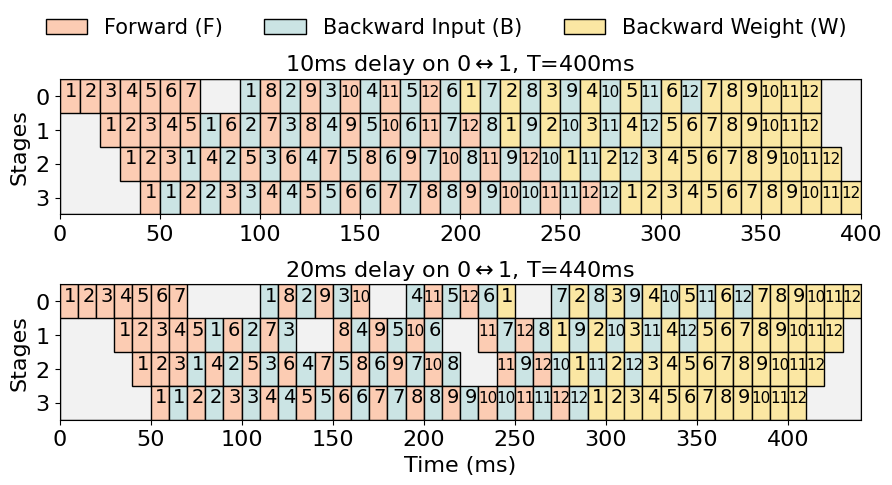

In [3]:
'''The following code produces Figure.5 in the paper: the non-linear accumulated dealy of ZeroBubble due to communication delay'''
num_stages, num_batches = 4, 12
update_times([10]*num_stages, [10]*num_stages, [10]*num_stages, [1]*num_stages)
policy = OurPolicy(num_stages)
simulator = PipelineSimulator(num_stages, num_batches, policy, [], {}, True)
simulator.simulate()
simulator.export("../../experiments/simulation/originalzb.txt")
plt.figure(figsize=(9, 5))
ax = plt.subplot(211)
simulator = PipelineSimulator(num_stages, num_batches, FixedPolicy(num_stages, '../../experiments/simulation/originalzb.txt'), [], {(0, 1): 10}, True)
simulator.simulate()
simulator.plot(ax)
plt.ylabel("Stages", fontdict={"fontsize": 16})
plt.title(f"10ms delay on 0$\\leftrightarrow$1, T={simulator.get_iter_time():.0f}ms", fontdict={"fontsize": 16})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax  = plt.subplot(212)
simulator = PipelineSimulator(num_stages, num_batches, FixedPolicy(num_stages, '../../experiments/simulation/originalzb.txt'), [], {(0, 1): 20}, True)
simulator.simulate()
simulator.plot(ax)
plt.title(f"20ms delay on 0$\\leftrightarrow$1, T={simulator.get_iter_time():.0f}ms", fontdict={"fontsize": 16})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Stages", fontdict={"fontsize": 16})
plt.bar(0, 0, label="Forward (F)", color=ForwardBatch(0).color, edgecolor='black')
plt.bar(0, 0, label="Backward Input (B)", color=BackwardInputBatch(0).color, edgecolor='black')
plt.bar(0, 0, label="Backward Weight (W)", color=BackwardWeightBatch(0).color, edgecolor='black')
plt.xlabel("Time (ms)", fontdict={"fontsize": 16})
legend = plt.figlegend(loc='upper center', bbox_to_anchor=(0.5, 0.98), fontsize=15, ncols=3, frameon=False)
plt.tight_layout(pad=1.0, rect=(0, 0, 1, 0.9)) 

plt.savefig("../../experiments/simulation/delayzb.pdf")

0
5
10
15
20


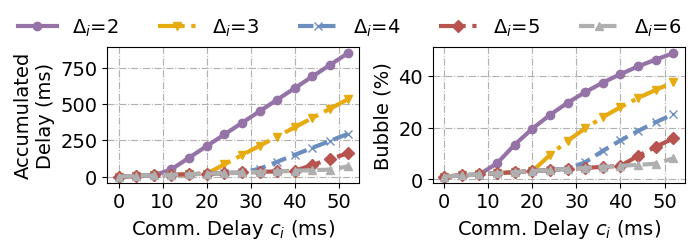

In [4]:
'''The following code produces Figure.8 in the paper: straggler resilience v.s. delta_i'''
num_stages, num_batches = 2, 30
update_times([10]*num_stages, [10]*num_stages, [10]*num_stages, [1]*num_stages)
LINESTYLES = ['-o', '-.v', '--x', '-.D', '--^']
COLORS = ['#9673A6', '#E7AB10', '#6C8EBF', '#B85450', '#AFAFAF']
lsid = 0
policy = OurPolicy(num_stages)
simulator = PipelineSimulator(num_stages, num_batches, policy, [], {}, True)
simulator.simulate()
health_time = simulator.get_iter_time()

fig, axs = plt.subplots(1, 2, figsize=(7, 2.5))

for sched_delay in range(0, 25, 5):
    print(sched_delay)
    policy = OurPolicy(num_stages)
    simulator = PipelineSimulator(num_stages, num_batches, policy, [], {(0, 1): sched_delay}, True)
    simulator.simulate()
    simulator.export("../../experiments/simulation/originalzb.txt")
    iter_times = []
    bbrs = []
    for delay_time in range(0, 55, 4):
        comm_delay = {(0, 1): delay_time}
        policy = FixedPolicy(num_stages, "../../experiments/simulation/originalzb.txt")
        simulator = PipelineSimulator(num_stages, num_batches, policy, [], comm_delay, True)
        simulator.simulate()
        iter_time = simulator.get_iter_time()
        iter_times.append(iter_time)
        bbrs.append(simulator.get_bubble_rate())
    maxdx = sched_delay // 5 + 2 #np.max(calc_delta_x("./originalzb.txt"))
    axs[0].plot(list(range(0, 55, 4)), np.array(iter_times) - health_time, LINESTYLES[lsid], color=COLORS[lsid], linewidth=3)
    axs[1].plot(list(range(0, 55, 4)), bbrs, LINESTYLES[lsid], color=COLORS[lsid], linewidth=3, label=f"$\\Delta_i$={maxdx}")
    lsid += 1

legend = plt.figlegend(loc='upper center', bbox_to_anchor=(0.5, 1.02), fontsize=14, ncols=5, frameon=False)
axs[0].set_xlabel(r"Comm. Delay $c_i$ (ms)", fontdict={"fontsize": 14})
axs[1].set_xlabel(r"Comm. Delay $c_i$ (ms)", fontdict={"fontsize": 14})
axs[0].set_ylabel("Accumulated\nDelay (ms)", fontdict={"fontsize": 14})
axs[1].set_ylabel("Bubble (%)", fontdict={"fontsize": 14})
axs[0].grid(linestyle='-.')
axs[1].grid(linestyle='-.')
for i in range(2):
    plt.sca(axs[i])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.tight_layout(pad=1.05, rect=(0, 0, 1, 0.9)) 
plt.savefig("../../experiments/simulation/simudelay.pdf")

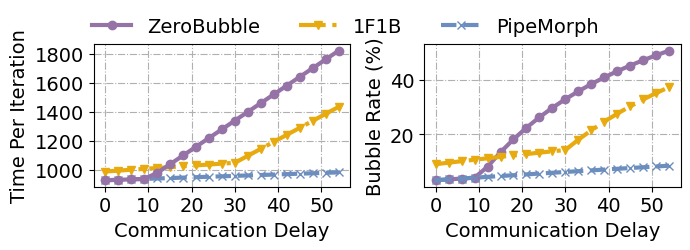

In [5]:
'''The following code compares delay resilience of ZB, 1F1B, and PipeMorph'''
num_stages, num_batches = 4, 30
update_times([10]*num_stages, [10]*num_stages, [10]*num_stages, [1]*num_stages)
ls = ['-x', '-o', '-v', '-d', '-D']

LINESTYLES = ['-o', '-.v', '--x', '-.D']
COLORS = ['#9673A6', '#E7AB10', '#6C8EBF', '#B85450']

lsid = 0
policy = OurPolicy(num_stages)
simulator = PipelineSimulator(num_stages, num_batches, policy, [], {}, True)
simulator.simulate()
health_time = simulator.get_iter_time()
slow_link = (2, 3)
fig, axs = plt.subplots(1, 2, figsize=(7, 2.5))

# ZB
policy = OurPolicy(num_stages)
simulator = PipelineSimulator(num_stages, num_batches, policy, [], {}, True)
simulator.simulate()
simulator.export("../../experiments/simulation/originalzb.txt")
iter_times, bubbles = [], []
for delay_time in range(0, 55, 3):
    comm_delay = {slow_link: delay_time}
    policy = FixedPolicy(num_stages, "../../experiments/simulation/originalzb.txt")
    simulator = PipelineSimulator(num_stages, num_batches, policy, [], comm_delay, True)
    simulator.simulate()
    iter_time = simulator.get_iter_time()
    iter_times.append(iter_time)
    bubbles.append(simulator.get_bubble_rate())
axs[0].plot(list(range(0, 55, 3)), np.array(iter_times), LINESTYLES[lsid], color=COLORS[lsid], linewidth=3, label=f"ZeroBubble", zorder=100)
axs[1].plot(list(range(0, 55, 3)), np.array(bubbles), LINESTYLES[lsid], linewidth=3, color=COLORS[lsid])
lsid += 1

# 1F1B
policy = PipeDreamPolicy(num_stages)
simulator = PipelineSimulator(num_stages, num_batches, policy, [], {}, False)
simulator.simulate()
simulator.export("../../experiments/simulation/1f1b.txt")
iter_times, bubbles = [], []
for delay_time in range(0, 55, 3):
    comm_delay = {slow_link: delay_time}
    policy = FixedPolicy(num_stages, "../../experiments/simulation/1f1b.txt")
    simulator = PipelineSimulator(num_stages, num_batches, policy, [], comm_delay, False)
    simulator.simulate()
    iter_time = simulator.get_iter_time()
    iter_times.append(iter_time)
    bubbles.append(simulator.get_bubble_rate())
axs[0].plot(list(range(0, 55, 3)), np.array(iter_times), LINESTYLES[lsid], color=COLORS[lsid], linewidth=3, label=f"1F1B")
axs[1].plot(list(range(0, 55, 3)), np.array(bubbles), LINESTYLES[lsid], linewidth=3, color=COLORS[lsid])
lsid += 1

# Ours
iter_times, bubbles = [], []
for delay_time in range(0, 55, 3):
    comm_delay = {slow_link: delay_time}
    policy = OurPolicy(num_stages)
    simulator = PipelineSimulator(num_stages, num_batches, policy, [], comm_delay, True)
    simulator.simulate()
    iter_time = simulator.get_iter_time()
    iter_times.append(iter_time)
    bubbles.append(simulator.get_bubble_rate())
axs[0].plot(list(range(0, 55, 3)), np.array(iter_times), LINESTYLES[lsid], linewidth=3, color=COLORS[lsid], label=f"PipeMorph")
axs[1].plot(list(range(0, 55, 3)), np.array(bubbles), LINESTYLES[lsid], linewidth=3, color=COLORS[lsid])
lsid += 1

for i in range(2):
    axs[i].set_xlabel("Communication Delay", fontdict={"fontsize": 14})
    axs[i].set_ylabel("Time Per Iteration" if i == 0 else "Bubble Rate (%)", fontdict={"fontsize": 14})
    axs[i].grid(linestyle='-.')
    plt.sca(axs[i])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
legend = plt.figlegend(loc='upper center', bbox_to_anchor=(0.5, 1.02), fontsize=14, ncols=3, frameon=False)
plt.tight_layout(pad=1.05, rect=(0, 0, 1, 0.9)) 
plt.savefig("../../experiments/simulation/compbubble.pdf")

/tmp/ipykernel_1503687/3771539678.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("../../experiments/simulation/result.csv", sep=', ')


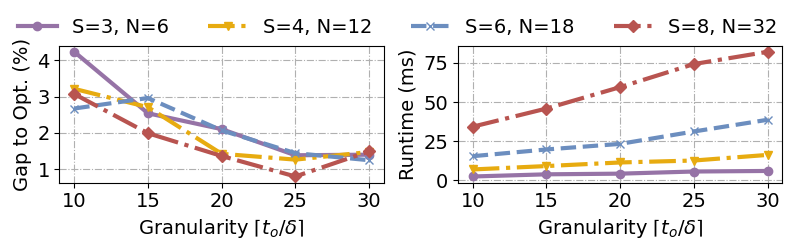

In [6]:
'''The following code produces Figure.19 in the paper: the optimality of our proposed algorithm'''
plt.figure(figsize=(8, 2.5))
df = pd.read_csv("../../experiments/simulation/result.csv", sep=', ')
ilp_t = df['ilp_t'].to_numpy()
our_t = df['our_t'].to_numpy()
our_cost = df['our_cost'].to_numpy()
diff = (our_t - ilp_t) / ilp_t

n_settings = 4
deltas = 5
repeats = 5
N = deltas * repeats
ls = ['-o', '-x', '-v', '-D']
labels=[(3, 6), (4, 12), (6, 18), (8, 32)]
xticks = [10, 15, 20, 25, 30]

plt.subplot(121)
for i in range(n_settings):
    data = diff[i * N : (i + 1) * N].reshape((deltas, repeats))
    d = np.mean(data, axis=1)
    plt.plot(d * 100, LINESTYLES[i], linewidth=3, color=COLORS[i], label=f'S={labels[i][0]}, N={labels[i][1]}')
    # plt.errorbar(np.arange(len(d)), d, yerr=np.std(data, axis=1), c='black')
plt.xlabel(r"Granularity $\lceil t_o/\delta \rceil$", fontdict={"fontsize": 14})
plt.ylabel("Gap to Opt. (%)", fontdict={"fontsize": 14})
plt.grid(linestyle='-.')
plt.xticks(np.arange(deltas), [str(i) for i in xticks], fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
for i in range(n_settings):
    data = our_cost[i * N : (i + 1) * N].reshape((deltas, repeats))
    cost_t = np.mean(data, axis=1)
    plt.plot(1000 * cost_t, LINESTYLES[i], color=COLORS[i], linewidth=3)

plt.xlabel(r"Granularity $\lceil t_o/\delta \rceil$", fontdict={"fontsize": 14})
plt.ylabel("Runtime (ms)", fontdict={"fontsize": 14})
plt.grid(linestyle='-.')
plt.xticks(np.arange(deltas), [str(i) for i in xticks], fontsize=14)
plt.yticks(fontsize=14)


legend = plt.figlegend(loc='upper center', bbox_to_anchor=(0.5, 1.02), fontsize=14, ncols=4, frameon=False)
plt.tight_layout(pad=1.1, rect=(0, 0, 1, 0.9)) 
plt.savefig("../../experiments/simulation/schedulecost.pdf")